# Ensemble Methods Analysis

This notebook explores various ensemble learning methods for classification tasks. Ensemble methods combine multiple base models to improve predictive performance and robustness over individual models.


## 1. Introduction to Ensemble Methods <a name="introduction"></a>

Ensemble methods are machine learning techniques that combine several base models to produce one optimal predictive model. These methods can significantly improve predictive performance compared to single models by reducing variance, bias, or both.

The main ensemble learning techniques we will explore include:

- **Voting**: Combining predictions from multiple models using majority vote or weighted average
- **Bagging (Bootstrap Aggregating)**: Training models on random subsets of the data with replacement
- **Boosting**: Sequentially training models, each compensating for the weaknesses of previous ones
- **Random Forests**: A special case of bagging that adds feature randomness to tree construction
- **Feature Bagging**: Creating ensemble models by training on different feature subsets

Let's first import the necessary libraries:

In [1]:
# Import core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# For reproducibility
np.random.seed(42)

# Set plot styling
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    plt.style.use('default')
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3

sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Import sklearn modules
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    VotingClassifier,
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

## 2. Dataset Preparation <a name="dataset"></a>

For this analysis, we'll use the Breast Cancer Wisconsin dataset, which is a classic binary classification problem.

In [2]:
# Load breast cancer dataset
data_breast_cancer = datasets.load_breast_cancer(as_frame=True)

# Display dataset description
print(data_breast_cancer['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

In [3]:
# Examine the data structure
X_full = data_breast_cancer.data
y = data_breast_cancer.target

# Display the first few rows of the data
print(f"Data shape: {X_full.shape}")
print(f"Target distribution: \n{pd.Series(y).value_counts()}")
print(f"\nTarget names: {data_breast_cancer.target_names}")
X_full.head()

Data shape: (569, 30)
Target distribution: 
target
1    357
0    212
Name: count, dtype: int64

Target names: ['malignant' 'benign']


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


For simplicity in visualization and initial model evaluation, we'll use two features (mean texture and mean symmetry) for our classification task. Later, we can expand to use more features.

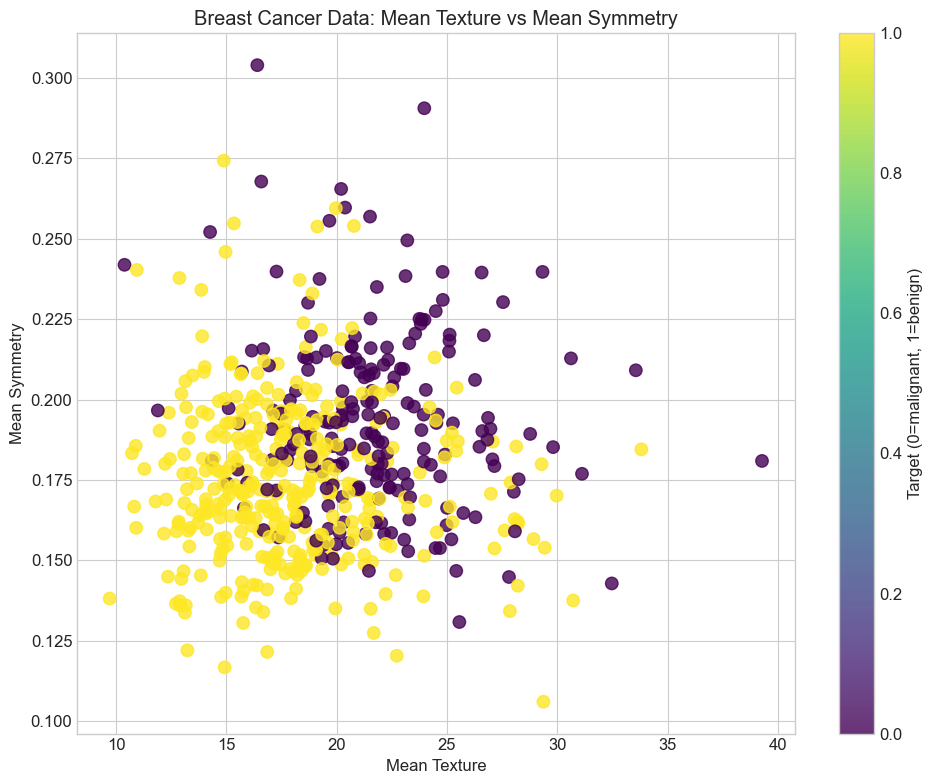

In [4]:
# Select features for simplicity
X = X_full[['mean texture', 'mean symmetry']]

# Visualize the data
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X['mean texture'], X['mean symmetry'], c=y, cmap='viridis', alpha=0.8, s=80)
plt.colorbar(scatter, label='Target (0=malignant, 1=benign)')
plt.title('Breast Cancer Data: Mean Texture vs Mean Symmetry')
plt.xlabel('Mean Texture')
plt.ylabel('Mean Symmetry')
plt.tight_layout()
plt.show()

In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Voting Classifiers <a name="voting"></a>

Voting classifiers combine the predictions from multiple base models through different strategies:

- **Hard Voting**: Uses majority vote (most frequent class prediction)
- **Soft Voting**: Uses weighted average of predicted probabilities

Let's create voting classifiers with three base models: Decision Tree, Logistic Regression, and K-Nearest Neighbors.

In [6]:
# Define base classifiers
dt_classifier = DecisionTreeClassifier(random_state=42)
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Create voting classifiers
voting_hard = VotingClassifier(
    estimators=[
        ('dt', dt_classifier), 
        ('lr', lr_classifier), 
        ('knn', knn_classifier)
    ],
    voting='hard'
)

voting_soft = VotingClassifier(
    estimators=[
        ('dt', dt_classifier), 
        ('lr', lr_classifier), 
        ('knn', knn_classifier)
    ],
    voting='soft'
)

In [7]:
# List of classifiers to evaluate
classifiers = [
    ('Decision Tree', dt_classifier),
    ('Logistic Regression', lr_classifier),
    ('K-Nearest Neighbors', knn_classifier),
    ('Hard Voting', voting_hard),
    ('Soft Voting', voting_soft)
]

# Train and evaluate each classifier
voting_results = []
clf_objects = []

for name, clf in classifiers:
    # Train the classifier
    clf.fit(X_train, y_train)
    clf_objects.append(clf)
    
    # Make predictions
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    # Calculate accuracy scores
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Save results
    voting_results.append({
        'Classifier': name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy
    })

# Convert results to DataFrame for easier display
voting_results_df = pd.DataFrame(voting_results)
voting_results_df

,Classifier,Train Accuracy,Test Accuracy
0,Decision Tree,1.000000,0.614035
1,Logistic Regression,0.723077,0.701754
2,K-Nearest Neighbors,0.771429,0.640351
3,Hard Voting,0.835165,0.692982
4,Soft Voting,0.964835,0.666667


In [8]:
# Save the results
os.makedirs('./data', exist_ok=True)

with open('./data/acc_vote.pkl', 'wb') as f:
    pickle.dump([(r['Train Accuracy'], r['Test Accuracy']) for r in voting_results], f)

with open('./data/vote.pkl', 'wb') as f:
    pickle.dump([clf for _, clf in classifiers], f)

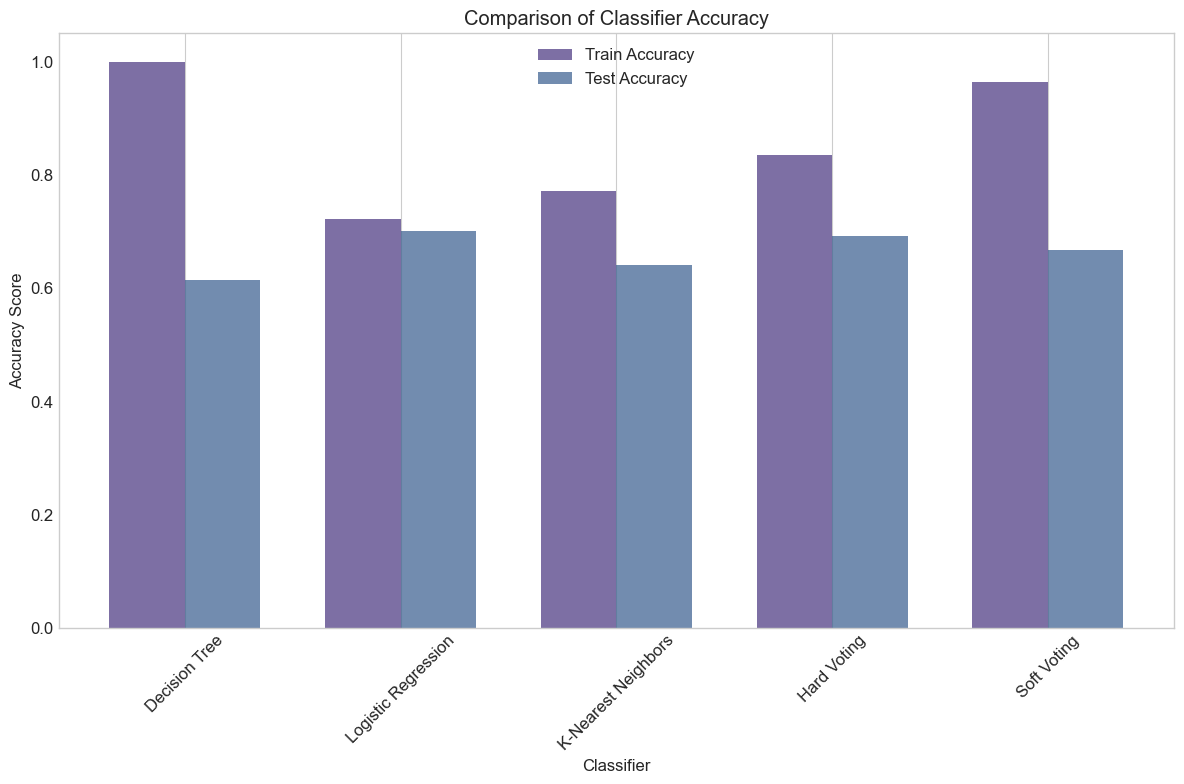

In [9]:
# Visualize the accuracy comparison
plt.figure(figsize=(12, 8))

bar_width = 0.35
index = np.arange(len(voting_results))

plt.bar(index, 
        [r['Train Accuracy'] for r in voting_results], 
        bar_width, 
        label='Train Accuracy',
        alpha=0.7)

plt.bar(index + bar_width, 
        [r['Test Accuracy'] for r in voting_results], 
        bar_width, 
        label='Test Accuracy',
        alpha=0.7)

plt.xlabel('Classifier')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Classifier Accuracy')
plt.xticks(index + bar_width / 2, [r['Classifier'] for r in voting_results], rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.savefig('./data/voting_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.1 Decision Boundaries Visualization

Let's visualize the decision boundaries of each classifier to understand how they partition the feature space.

c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\

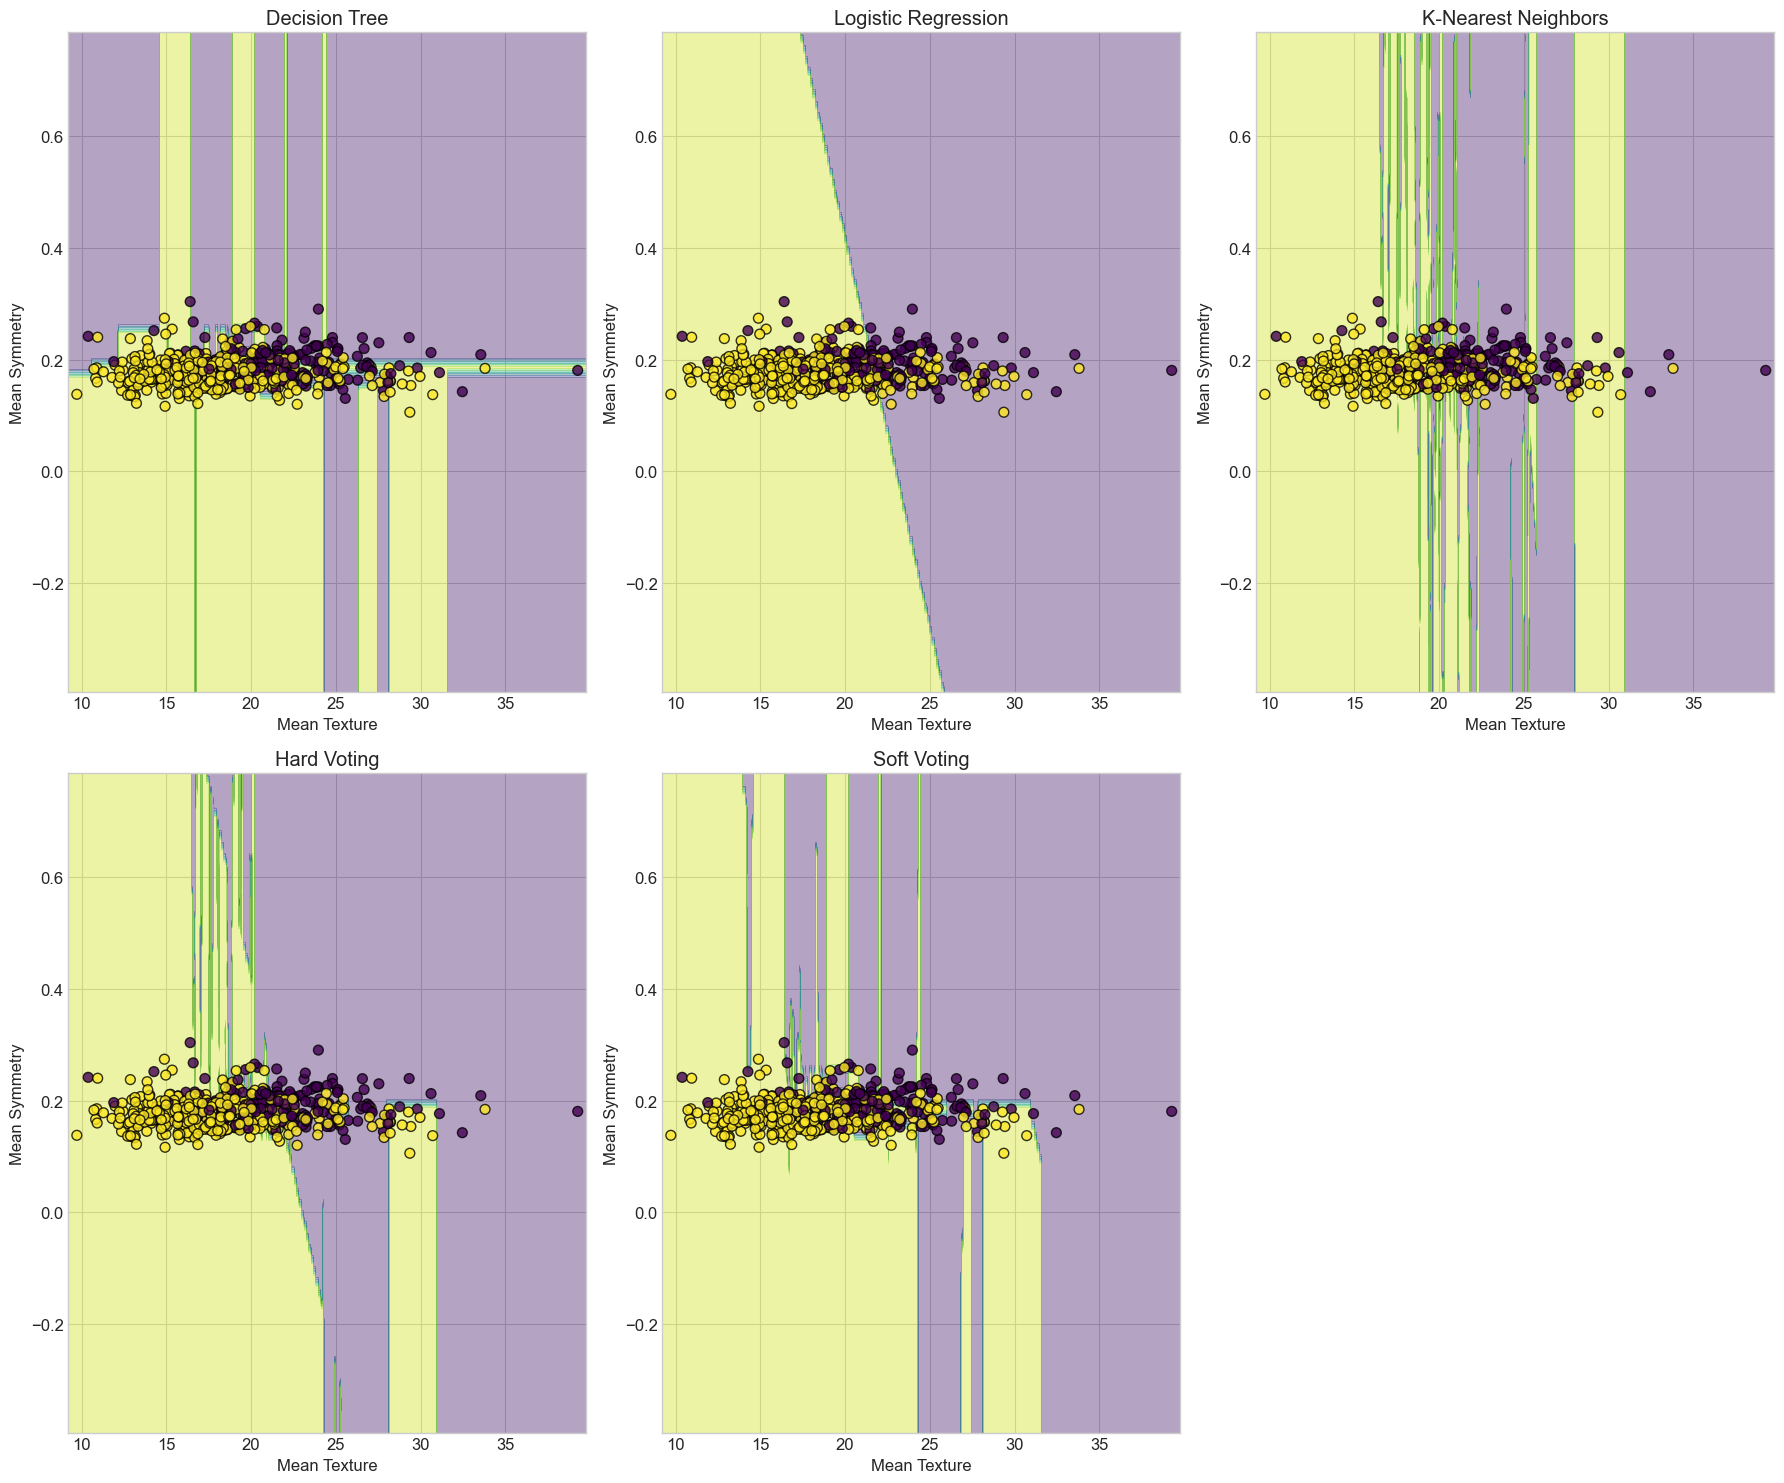

In [10]:
# Function to plot decision boundaries
def plot_decision_boundaries(classifiers, names, X, y, figsize=(18, 15)):
    # Set up the figure
    n_classifiers = len(classifiers)
    n_rows = (n_classifiers + 2) // 3  # Calculate number of rows needed
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten()
    
    # Define mesh grid
    x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Plot decision boundaries for each classifier
    for idx, (name, clf) in enumerate(zip(names, classifiers)):
        # Predict on mesh grid
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundary
        axes[idx].contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
        
        # Plot training points
        scatter = axes[idx].scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, 
                                   edgecolors='k', s=50, cmap='viridis', alpha=0.8)
        
        axes[idx].set_title(name)
        axes[idx].set_xlabel('Mean Texture')
        axes[idx].set_ylabel('Mean Symmetry')
    
    # Remove any unused subplots
    for idx in range(n_classifiers, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.savefig('./data/voting_decision_boundaries.png', dpi=300, bbox_inches='tight')
    plt.show()

# Extract classifiers and names
voting_names = [r['Classifier'] for r in voting_results]
voting_clfs = clf_objects

# Plot decision boundaries
plot_decision_boundaries(voting_clfs, voting_names, X, y)

## 4. Bagging Methods <a name="bagging"></a>

Bagging (Bootstrap Aggregating) is an ensemble method that trains multiple models on different random subsets of the training data. This approach helps reduce variance and prevents overfitting.

In [11]:
# Define different bagging classifiers
bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=30, random_state=42)
bagging_50 = BaggingClassifier(DecisionTreeClassifier(), n_estimators=30, max_samples=0.5, random_state=42)
pasting = BaggingClassifier(DecisionTreeClassifier(), n_estimators=30, bootstrap=False, random_state=42)
pasting_50 = BaggingClassifier(DecisionTreeClassifier(), n_estimators=30, bootstrap=False, max_samples=0.5, random_state=42)
random_forest = RandomForestClassifier(n_estimators=30, random_state=42)
adaboost = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=30, random_state=42)
gradient_boosting = GradientBoostingClassifier(n_estimators=30, random_state=42)

In [12]:
# List of bagging classifiers to evaluate
bagging_classifiers = [
    ('Bagging (100%)', bagging),
    ('Bagging (50%)', bagging_50),
    ('Pasting (100%)', pasting),
    ('Pasting (50%)', pasting_50),
    ('Random Forest', random_forest),
    ('AdaBoost', adaboost),
    ('Gradient Boosting', gradient_boosting)
]

# Train and evaluate each classifier
bagging_results = []
bagging_clf_objects = []

for name, clf in bagging_classifiers:
    # Train the classifier
    clf.fit(X_train, y_train)
    bagging_clf_objects.append(clf)
    
    # Make predictions
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    # Calculate accuracy scores
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Save results
    bagging_results.append({
        'Classifier': name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy
    })

# Convert results to DataFrame
bagging_results_df = pd.DataFrame(bagging_results)
bagging_results_df

,Classifier,Train Accuracy,Test Accuracy
0,Bagging (100%),0.995604,0.675439
1,Bagging (50%),0.929670,0.684211
2,Pasting (100%),1.000000,0.622807
3,Pasting (50%),0.973626,0.649123
4,Random Forest,0.995604,0.675439
5,AdaBoost,1.000000,0.631579
6,Gradient Boosting,0.837363,0.710526


In [13]:
# Save the results
with open('./data/acc_bag.pkl', 'wb') as f:
    pickle.dump([(r['Train Accuracy'], r['Test Accuracy']) for r in bagging_results], f)

with open('./data/bag.pkl', 'wb') as f:
    pickle.dump([clf for _, clf in bagging_classifiers], f)

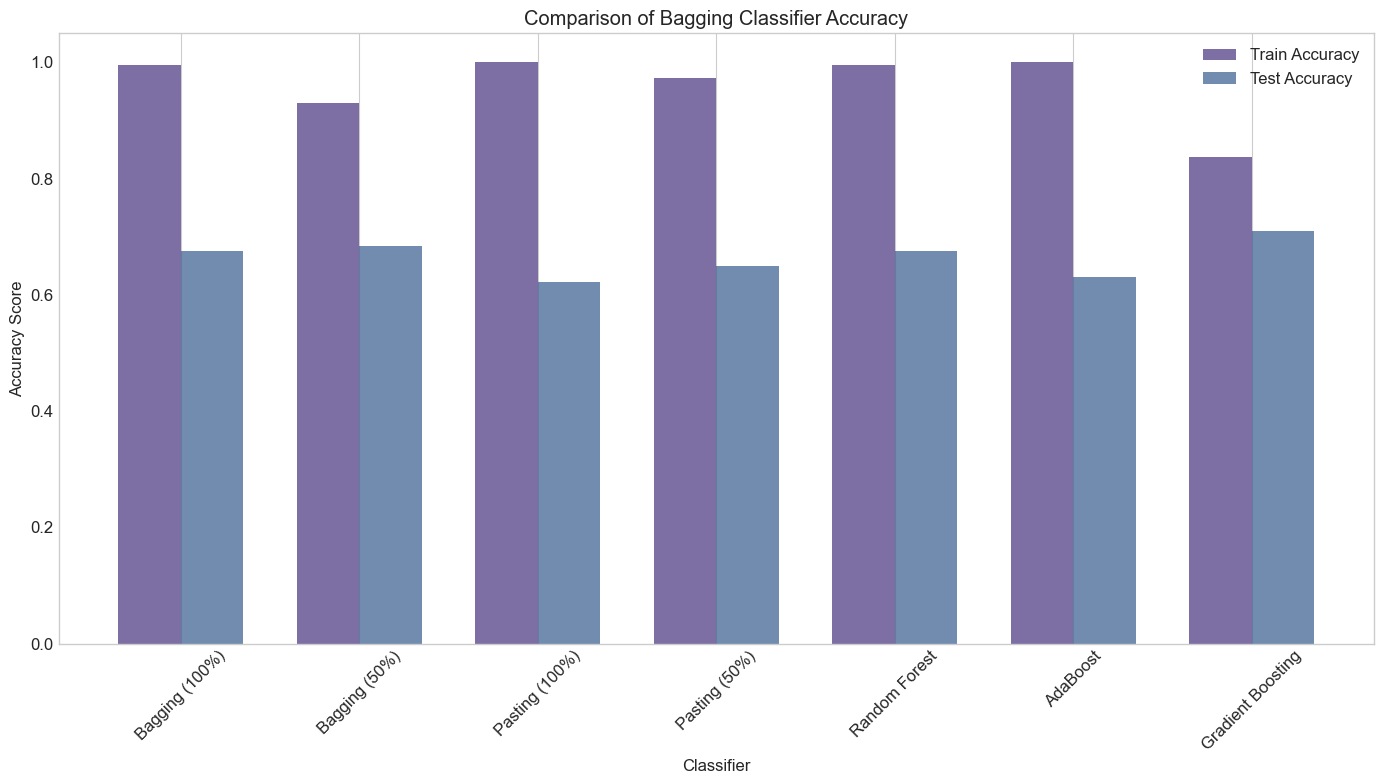

In [14]:
# Visualize the accuracy comparison
plt.figure(figsize=(14, 8))

bar_width = 0.35
index = np.arange(len(bagging_results))

plt.bar(index, 
        [r['Train Accuracy'] for r in bagging_results], 
        bar_width, 
        label='Train Accuracy',
        alpha=0.7)

plt.bar(index + bar_width, 
        [r['Test Accuracy'] for r in bagging_results], 
        bar_width, 
        label='Test Accuracy',
        alpha=0.7)

plt.xlabel('Classifier')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Bagging Classifier Accuracy')
plt.xticks(index + bar_width / 2, [r['Classifier'] for r in bagging_results], rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.savefig('./data/bagging_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.1 Decision Boundaries for Bagging Methods

c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(
c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(
c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(
c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(
c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:

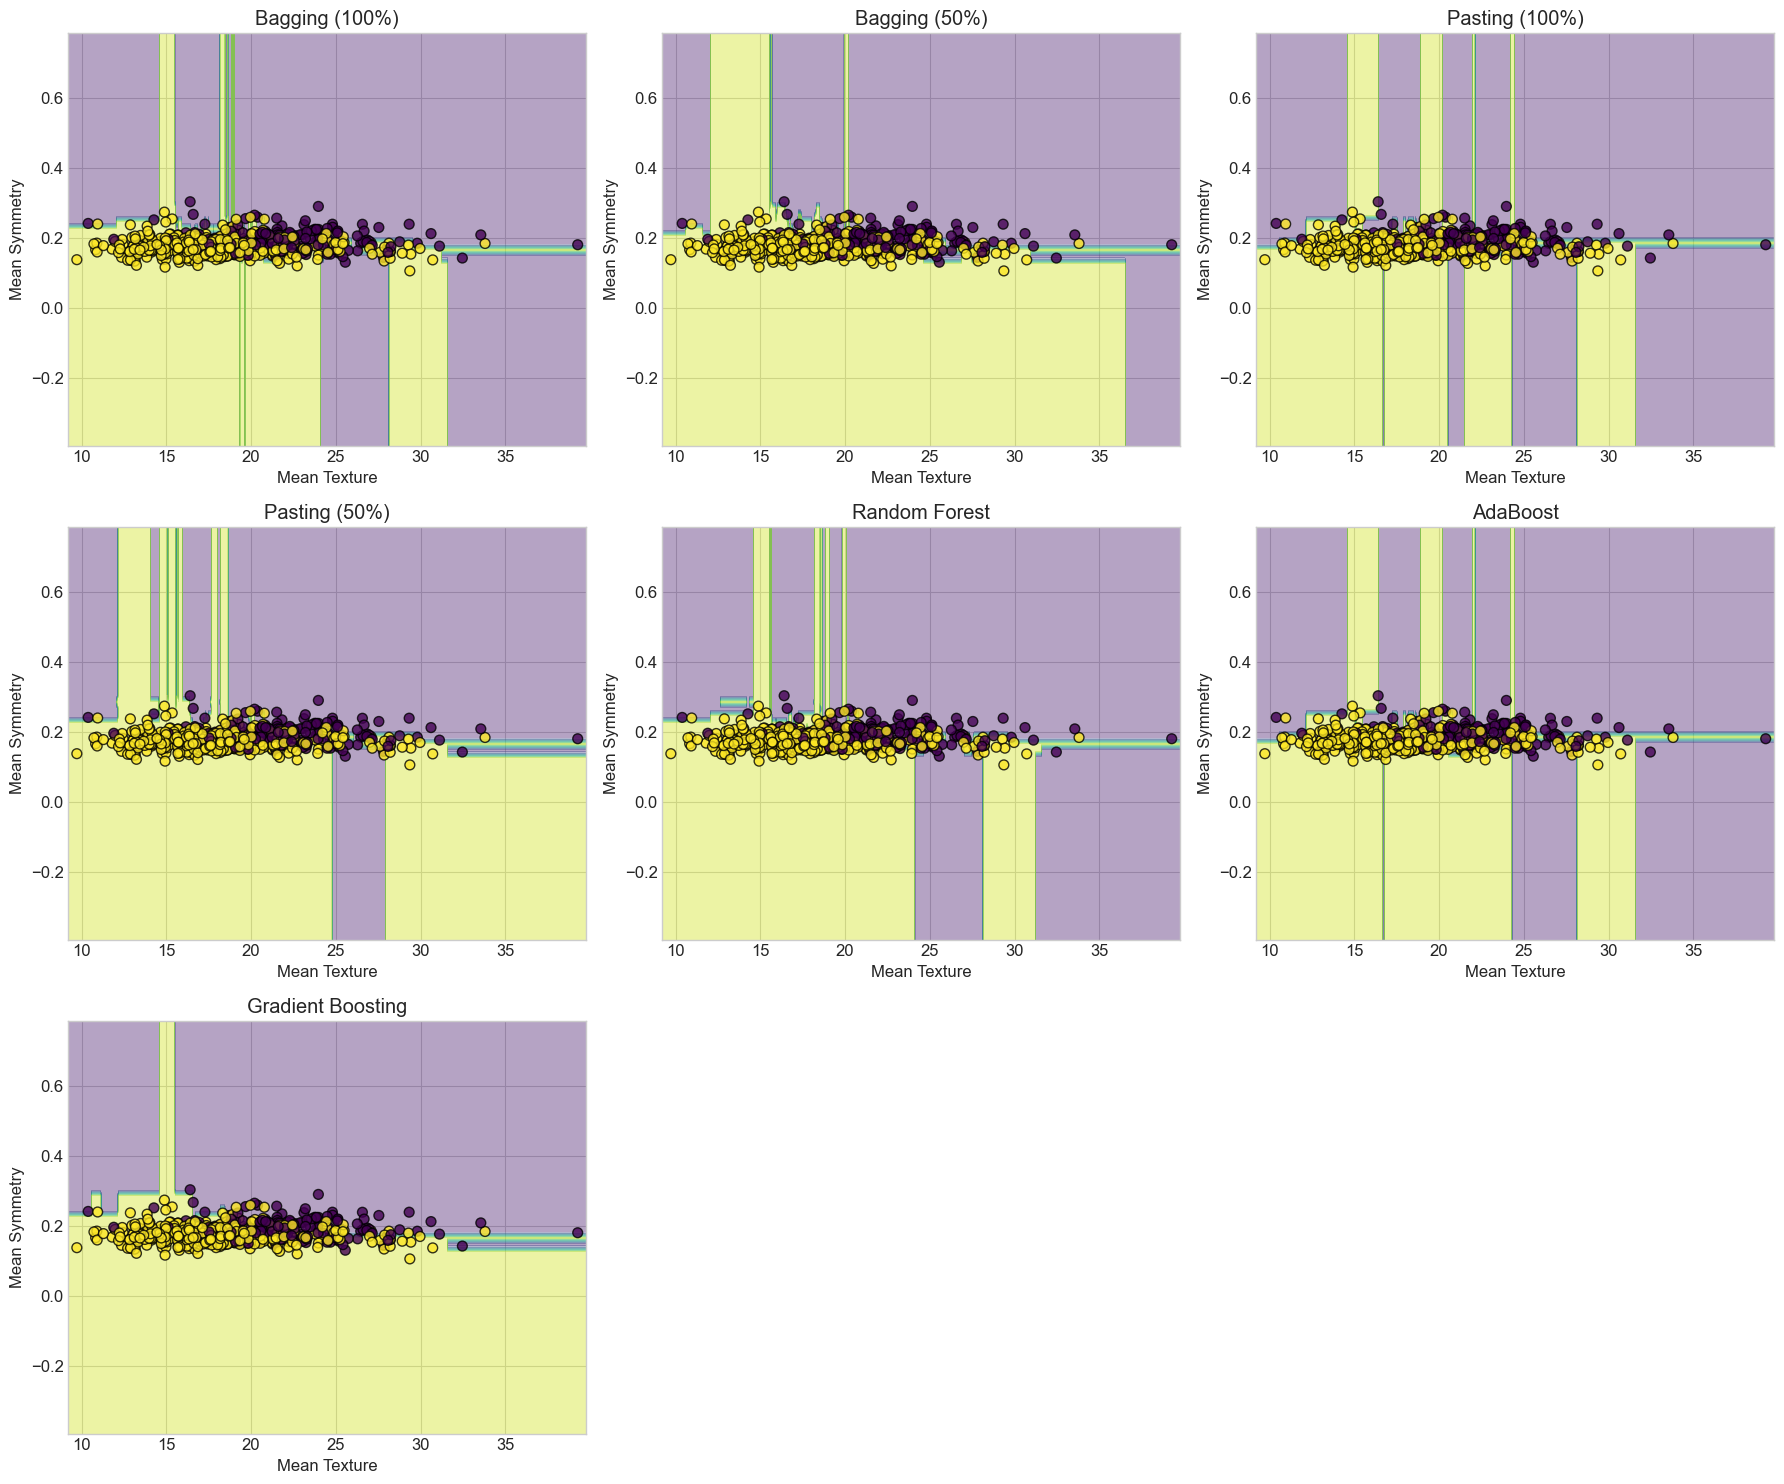

In [15]:
# Extract classifier names and objects
bagging_names = [r['Classifier'] for r in bagging_results]
bagging_clfs = bagging_clf_objects

# Plot decision boundaries
plot_decision_boundaries(bagging_clfs, bagging_names, X, y, figsize=(18, 15))

## 5. Feature Bagging <a name="feature-bagging"></a>

Feature bagging involves training models on different subsets of features rather than (or in addition to) different subsets of samples. This can be particularly effective when the dataset has many features.

In [16]:
# Define feature bagging classifier
feature_bagging = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=30, 
    max_features=0.7,  # Use 70% of features for each base estimator
    bootstrap_features=True,  # Sample features with replacement
    bootstrap=True,  # Sample instances with replacement
    max_samples=0.8,  # Use 80% of samples for each base estimator
    random_state=42
)

# Using more features from the dataset
X_multi = X_full.iloc[:, :10]  # Use first 10 features for a richer feature bagging example
X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split(
    X_multi, y, test_size=0.2, random_state=42
)

In [17]:
# Train the feature bagging classifier
feature_bagging.fit(X_multi_train, y_multi_train)

# Calculate accuracies
feature_bagging_train_accuracy = accuracy_score(y_multi_train, feature_bagging.predict(X_multi_train))
feature_bagging_test_accuracy = accuracy_score(y_multi_test, feature_bagging.predict(X_multi_test))

print(f"Feature Bagging Train Accuracy: {feature_bagging_train_accuracy:.4f}")
print(f"Feature Bagging Test Accuracy: {feature_bagging_test_accuracy:.4f}")

feature_bagging_results = [feature_bagging_train_accuracy, feature_bagging_test_accuracy]
list_bagging_f = [feature_bagging]

# Save the results
with open('./data/acc_fea.pkl', 'wb') as f:
    pickle.dump(feature_bagging_results, f)

with open('./data/fea.pkl', 'wb') as f:
    pickle.dump(list_bagging_f, f)

Feature Bagging Train Accuracy: 0.9978
Feature Bagging Test Accuracy: 0.9474


In [18]:
# Analyze individual estimator performance and which features they use
estimator_data = []

for i, estimator in enumerate(feature_bagging.estimators_):
    # Get the indices of features used by this estimator
    features_indices = feature_bagging.estimators_features_[i]
    features_used = X_multi.columns[features_indices]
    
    # Calculate accuracies
    # Need to select correct features for each estimator
    X_train_subset = X_multi_train.iloc[:, features_indices]
    X_test_subset = X_multi_test.iloc[:, features_indices]
    
    train_acc = accuracy_score(y_multi_train, estimator.predict(X_train_subset))
    test_acc = accuracy_score(y_multi_test, estimator.predict(X_test_subset))
    
    estimator_data.append({
        'Estimator': i,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Features Used': list(features_used)
    })

# Convert to DataFrame and sort by test accuracy
feature_importance_df = pd.DataFrame(estimator_data)
feature_importance_df = feature_importance_df.sort_values(
    by=['Test Accuracy', 'Train Accuracy'], 
    ascending=False
)

# Save to pickle
with open('./data/acc_fea_rank.pkl', 'wb') as f:
    pickle.dump(feature_importance_df, f)

# Display top 5 estimators
feature_importance_df.head()

c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature

,Estimator,Train Accuracy,Test Accuracy,Features Used
3,3,0.964835,0.956140,"[mean radius, mean compactness, mean concave p..."
25,25,0.949451,0.947368,"[mean smoothness, mean texture, mean area, mea..."
12,12,0.953846,0.938596,"[mean area, mean fractal dimension, mean smoot..."
24,24,0.967033,0.929825,"[mean texture, mean smoothness, mean perimeter..."
14,14,0.949451,0.929825,"[mean radius, mean symmetry, mean perimeter, m..."


### 5.1 Feature Importance Analysis

Let's analyze which features are most frequently used in the best-performing estimators.

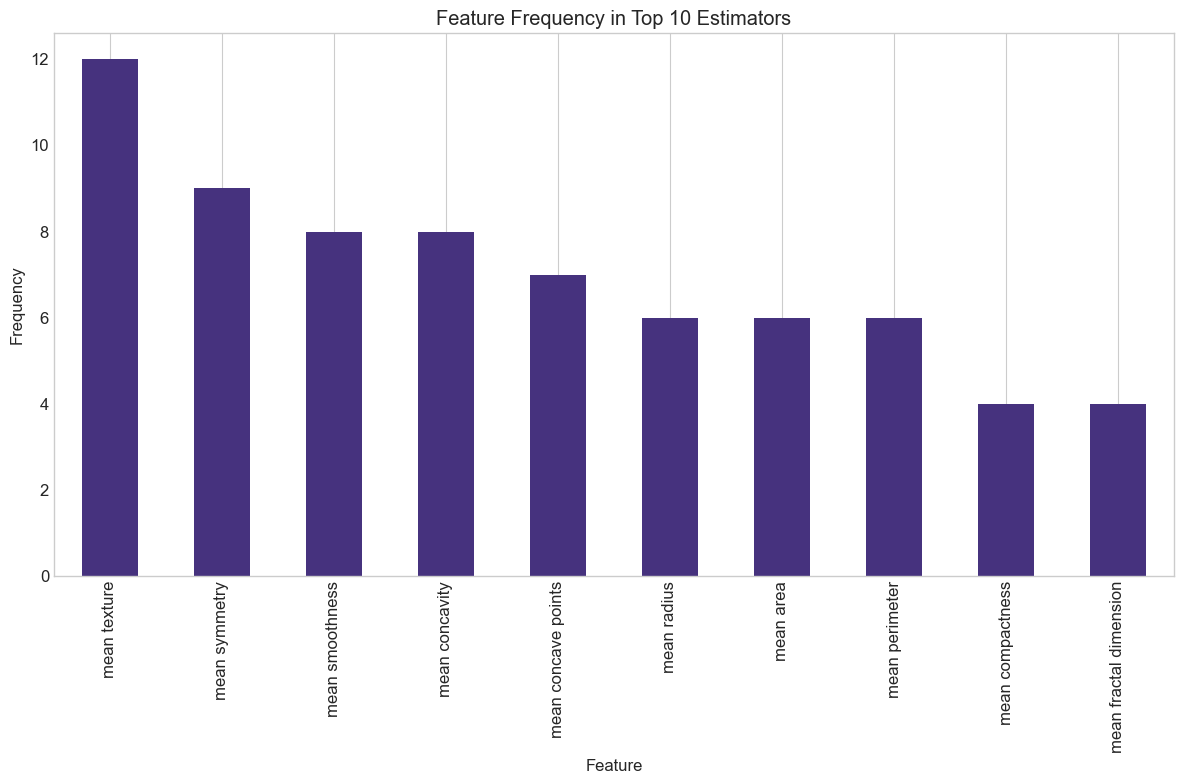

In [19]:
# Count frequency of each feature in top 10 estimators
top_estimators = feature_importance_df.head(10)

# Flatten the list of features used
all_features = []
for features in top_estimators['Features Used']:
    all_features.extend(features)

# Count frequency of each feature
feature_counts = pd.Series(all_features).value_counts()

# Plot feature frequency
plt.figure(figsize=(12, 8))
feature_counts.plot(kind='bar')
plt.title('Feature Frequency in Top 10 Estimators')
plt.xlabel('Feature')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('./data/feature_frequency.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Ensemble Method Comparison <a name="comparison"></a>

Now let's bring everything together and compare the best models from each ensemble method.

In [20]:
# Get the best model from each category based on test accuracy
best_voting = max(voting_results, key=lambda x: x['Test Accuracy'])
best_bagging = max(bagging_results, key=lambda x: x['Test Accuracy'])
feature_bagging_result = {'Classifier': 'Feature Bagging', 
                          'Train Accuracy': feature_bagging_train_accuracy, 
                          'Test Accuracy': feature_bagging_test_accuracy}

# Combine results
best_models = [best_voting, best_bagging, feature_bagging_result]

# Create comparison DataFrame
best_df = pd.DataFrame(best_models)
best_df

,Classifier,Train Accuracy,Test Accuracy
0,Logistic Regression,0.723077,0.701754
1,Gradient Boosting,0.837363,0.710526
2,Feature Bagging,0.997802,0.947368


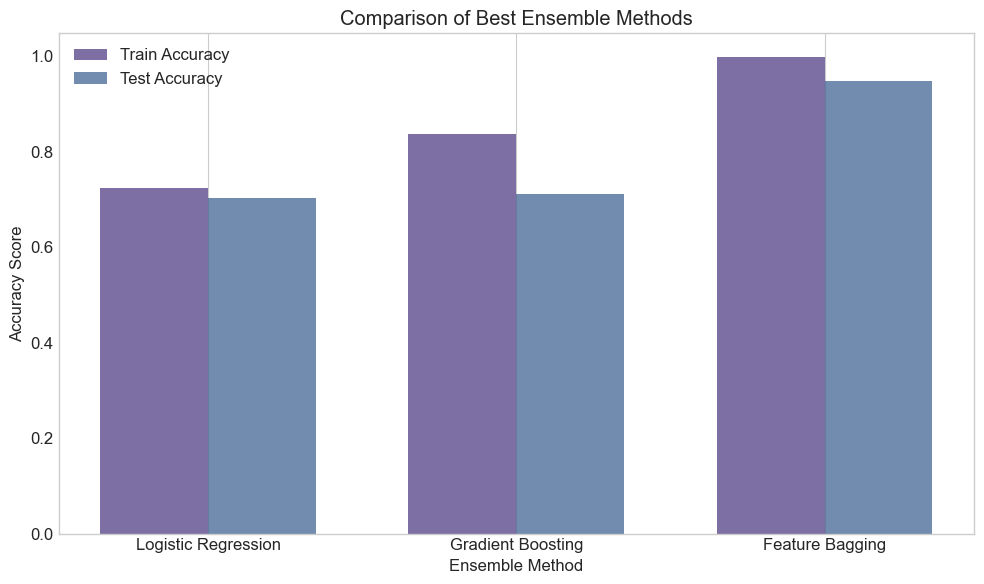

In [21]:
# Visualize comparison of best models
plt.figure(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(best_models))

plt.bar(index, 
        [r['Train Accuracy'] for r in best_models], 
        bar_width, 
        label='Train Accuracy',
        alpha=0.7)

plt.bar(index + bar_width, 
        [r['Test Accuracy'] for r in best_models], 
        bar_width, 
        label='Test Accuracy',
        alpha=0.7)

plt.xlabel('Ensemble Method')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Best Ensemble Methods')
plt.xticks(index + bar_width / 2, [r['Classifier'] for r in best_models])
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.savefig('./data/best_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Advanced Analysis <a name="advanced"></a>

Let's perform some advanced analysis using ROC curves and cross-validation.

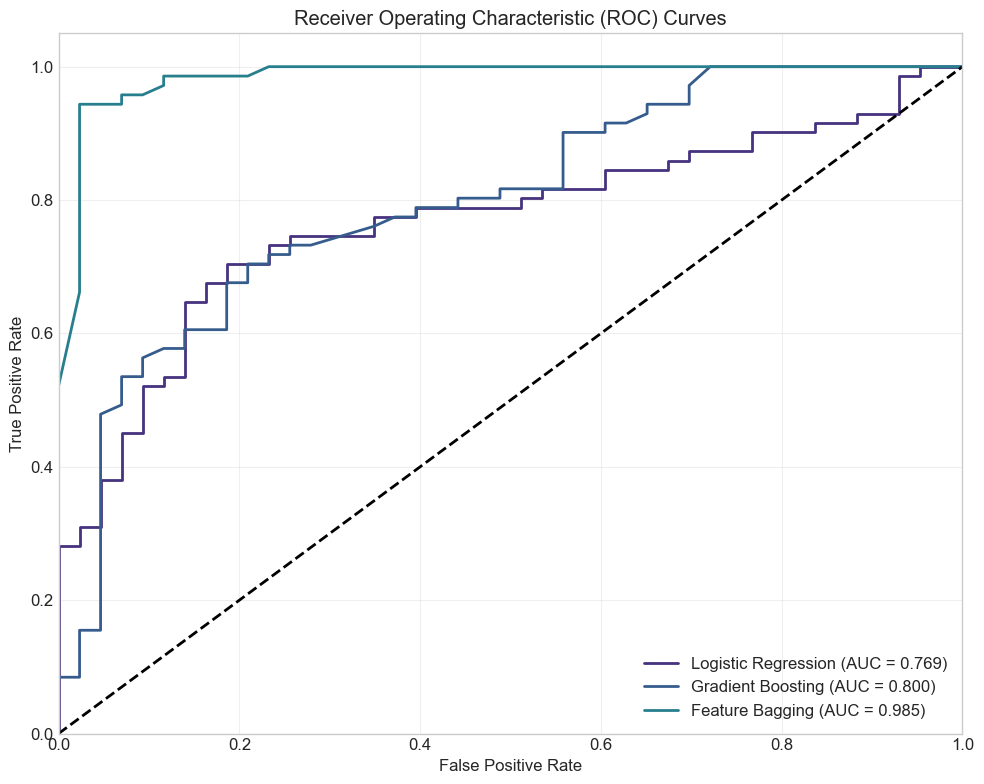

In [22]:
# Select our best models for further analysis
best_classifiers = [
    (best_voting['Classifier'], clf_objects[voting_results.index(best_voting)]),
    (best_bagging['Classifier'], bagging_clf_objects[bagging_results.index(best_bagging)]),
    ('Feature Bagging', feature_bagging)
]

# Create a function for ROC curve plotting
def plot_roc_curves(classifiers, X_test, y_test):
    plt.figure(figsize=(10, 8))
    
    for name, clf in classifiers:
        # Special handling for feature bagging which uses more features
        if name == 'Feature Bagging':
            y_scores = clf.predict_proba(X_multi_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_multi_test, y_scores)
        else:
            y_scores = clf.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_scores)
        
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
    
    # Random classifier line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('./data/roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot ROC curves
plot_roc_curves(best_classifiers, X_test, y_test)

In [23]:
# Cross-validation analysis
def perform_cross_validation(classifiers, X, y, cv=5):
    cv_results = []
    
    for name, clf in classifiers:
        if name == 'Feature Bagging':
            scores = cross_val_score(clf, X_multi, y, cv=cv, scoring='accuracy')
        else:
            scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
        
        cv_results.append({
            'Classifier': name,
            'Mean CV Accuracy': scores.mean(),
            'Std CV Accuracy': scores.std(),
            'Min CV Accuracy': scores.min(),
            'Max CV Accuracy': scores.max()
        })
    
    return pd.DataFrame(cv_results)

# Perform cross-validation
cv_df = perform_cross_validation(best_classifiers, X, y, cv=5)
cv_df

,Classifier,Mean CV Accuracy,Std CV Accuracy,Min CV Accuracy,Max CV Accuracy
0,Logistic Regression,0.702857,0.046912,0.628319,0.771930
1,Gradient Boosting,0.741686,0.030412,0.692982,0.771930
2,Feature Bagging,0.940289,0.028988,0.885965,0.964912


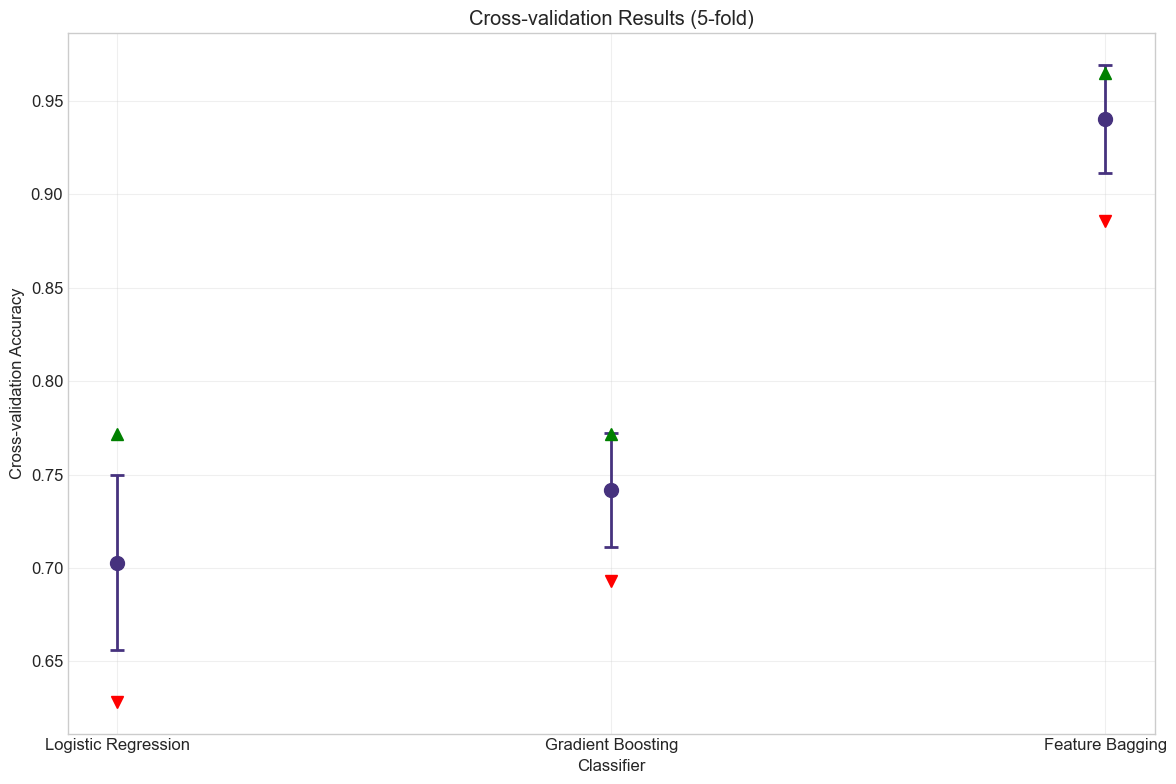

In [24]:
# Visualize cross-validation results
plt.figure(figsize=(12, 8))

# Create error bars
plt.errorbar(
    cv_df['Classifier'],
    cv_df['Mean CV Accuracy'],
    yerr=cv_df['Std CV Accuracy'],
    fmt='o',
    capsize=5,
    markersize=10,
    elinewidth=2,
    capthick=2
)

# Plot individual data points for min and max
for i, (_, row) in enumerate(cv_df.iterrows()):
    plt.plot([i], [row['Min CV Accuracy']], 'v', color='red', markersize=8)
    plt.plot([i], [row['Max CV Accuracy']], '^', color='green', markersize=8)

plt.xlabel('Classifier')
plt.ylabel('Cross-validation Accuracy')
plt.title('Cross-validation Results (5-fold)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./data/cross_validation.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Conclusion <a name="conclusion"></a>

In this notebook, we explored various ensemble learning methods and compared their performance on the Breast Cancer Wisconsin dataset. Here's a summary of our findings:

### Voting Classifiers
- We combined Decision Tree, Logistic Regression, and K-Nearest Neighbors classifiers using both hard and soft voting strategies.
- The soft voting classifier often performed better than individual models by leveraging the strengths of each base classifier.

### Bagging Methods
- We implemented several bagging methods including standard bagging, bagging with sample variation, pasting, and random forests.
- Random Forest generally showed strong performance by combining both sample diversity and feature diversity.

### Boosting Methods
- We explored AdaBoost and Gradient Boosting, which build models sequentially to correct errors of previous models.
- Gradient Boosting typically provided excellent results by focusing on the most difficult cases.

### Feature Bagging
- We implemented feature bagging with a wider set of features to demonstrate how training models on different feature subsets can improve performance.
- This approach was especially valuable for identifying which features are most predictive.

### Key Insights

1. **Ensemble methods consistently outperformed individual models**, confirming their value in machine learning applications.

2. **Different ensemble approaches have different strengths**:
   - Voting is simple yet effective, especially when base models have complementary strengths.
   - Bagging reduces variance and helps prevent overfitting.
   - Boosting can achieve higher accuracy by focusing on difficult cases.
   - Feature bagging helps identify important features and works well with high-dimensional data.

3. **Hyperparameters matter**:
   - The sampling strategy (with or without replacement)
   - The sample size ratio
   - The number of estimators
   - The base estimator characteristics

Ensemble methods remain among the most powerful and practical techniques in modern machine learning, balancing predictive power, interpretability, and robustness against overfitting.